# EMIT inference

NASA's Earth Surface Mineral Dust Source Investigation (EMIT) sensor is a hyperspectral imaging sensor mounted on the International Space Station.
It observes light in 285 spectral bands from the visible to short-wave infrared range.
Although its primary mission is to determine surface minerology, EMIT's high spectral resolution across methane-absorbing spectra makes it well suited to the task of detecting point-source methane emissions.
In this notebook we present and discuss a model trained on that task.

In [1]:
import numpy as np
import torch
import xarray as xr
from utils import EMIT_SCALING_FACTOR, plot_predictions, predict

## Model

We have trained a [U-Net++](https://smp.readthedocs.io/en/latest/models.html#unetplusplus) model with a [timm-efficientnet-b1](https://smp.readthedocs.io/en/latest/encoders.html) pretrained encoder.
The model uses all 285 EMIT bands for training and inference.
Below we load our trained model.

In [2]:
model = torch.load("./resources/emit/model.pth", weights_only=False, map_location="cpu")

## Data

Our model is trained on [EMIT L1B radiance](https://lpdaac.usgs.gov/products/emitl1bradv001/) data.
A description of the training and validation datasets is available in the docs [here](https://orbio-earth.github.io/project-eucalyptus/Hyperspectral.md#what-are-the-key-differences-between-the-training-data-and-model-for-multispectral-data-sentinel-2-and-hyperspectral-data-emit).
Here we have included a crop of EMIT granule `EMIT_L1B_RAD_001_20240812T213903_2422514_030` that contains known plumes identified by the United Nations Environment Programme's (UNEP's) International Methane Emissions Observatory (IMEO).
Although we have included only a crop to control data volume in the repository this notebook could also be used to load and run inference on entire granules.
Arbitrary EMIT L1B granules can be accessed through NASA's [Earthdata portal](earthdata.nasa.gov), the [earthaccess](https://earthaccess.readthedocs.io/en/latest/) Python module, or the NASA SpatioTemporal Asset Catalog (STAC) [here](https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/EMITL1BRAD_001).

Our model expects radiance values to have been scaled by `0.1`, which is applied below as `EMIT_SCALING_FACTOR`.

In [3]:
with xr.open_dataset("resources/emit/radiance_crop.nc") as ds:
    # get our data bands-first
    # calling load greatly speeds up the transpose operation for larger files
    radiance = ds["radiance"].load().transpose("bands", "downtrack", "crosstrack")

x = torch.from_numpy(radiance.values * EMIT_SCALING_FACTOR)[torch.newaxis, ...]

## Inference

### Predictions

At time of inference we generate three layers with per-pixel values.
- **likelihood score**: a value in $[0, 1]$ indicating how confident the model is that a pixel contains methane;
- **conditional prediction**: the estimated methane concentration in each pixel; and
- **marginal prediction**: the conditional prediction scaled by the likelihood score.

A full discussion of these layers is provided in the docs [here](https://orbio-earth.github.io/project-eucalyptus/Model.html#how-should-the-model-output-be-interpreted).

### Units

Our conditional and marginal predictions are $\gamma c$ where $c$ is the concentration of methane in $\frac{mol}{m^2}$ and $\gamma$ is a scaling factor for the path length of the light through the atmosphere.


#### What is gamma?

$$
\gamma = \frac{1}{cos(\theta_a)} + \frac{1}{cos(\theta_b)}
$$

where $\theta_a$ is the zenith angle of the sun and $\theta_b$ the zenith angle of the sensor.

$\gamma$ is typically in the range of $[2, 3)$ given that the sensor is often close to nadir and the sun is always well above the horizon at time of image acquisition.
This range makes sense physically as light must pass through the atmosphere twice: once from the sun to the surface and again having been reflected from the surface back to the satellite, and the greater the zenith angle of the sensor or the sun, the longer the path length is on each of those transits.

<div style="text-align: center;">
  <img src="resources/figures/gamma.png" width="300px" />
</div>

#### Why use gamma?

We have trained to predict $\gamma c$ as that is what the EMIT sensor observes;
if the light takes a longer path length through the atmosphere then it also takes a longer path length through the methane plume, resulting in greater absorption of light.
In other words the same concentration of methane can appear differently depending on the geometry between our sensor and the sun, and attempting to directly predict concentration would be an ill-posed problem.

#### How to retrieve concentrations

To get the concentration of methane we simply need to remove gamma.
The sensor and solar zeniths are provided in EMIT observation (`EMIT_L1B_OBS`) files, which are available for download alongside the radiance files.
We have included here a crop of the observation file corresponding to the example radiance crop.
Using this we can calculate gamma and then simply remove it from the marginal and conditional predictions.

In [4]:
yhat_gamma_concentration = predict(model, x)

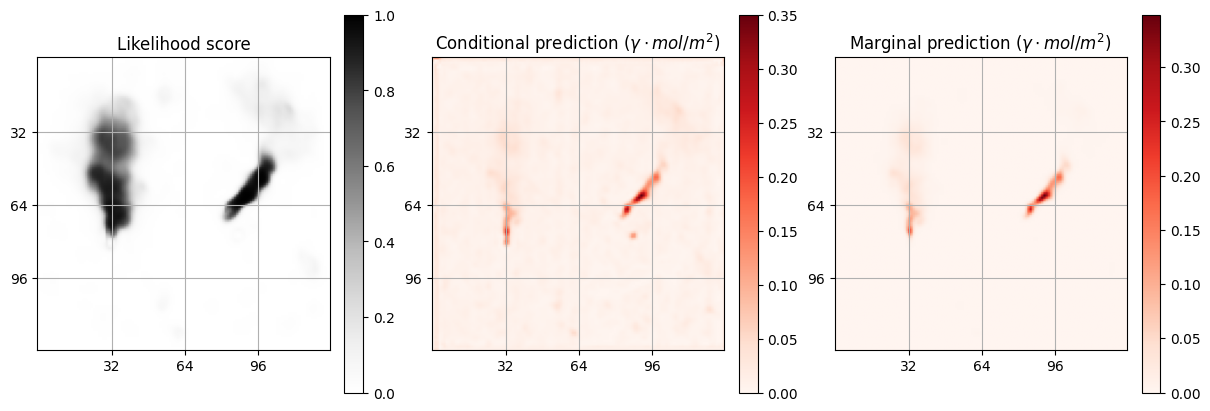

In [5]:
subplot_props = {
    "likelihood": {
        "title": "Likelihood score",
        "imshow_kwargs": {"cmap": "Greys", "vmin": 0, "vmax": 1},
    },
    "conditional": {
        "title": "Conditional prediction ({units})",
        "imshow_kwargs": {"cmap": "Reds", "vmin": 0},
    },
    "marginal": {
        "title": "Marginal prediction ({units})",
        "imshow_kwargs": {"cmap": "Reds", "vmin": 0},
    },
}

plot_predictions(
    yhat_gamma_concentration, subplot_props, units=r"$\gamma \cdot mol/m^2$"
)

Now let's remove gamma from our predictions to show just the concentrations.
These plots will look the same as the above, save that the scale of the conditional and marginal predictions has changed.

Mean gamma for crop: 2.36



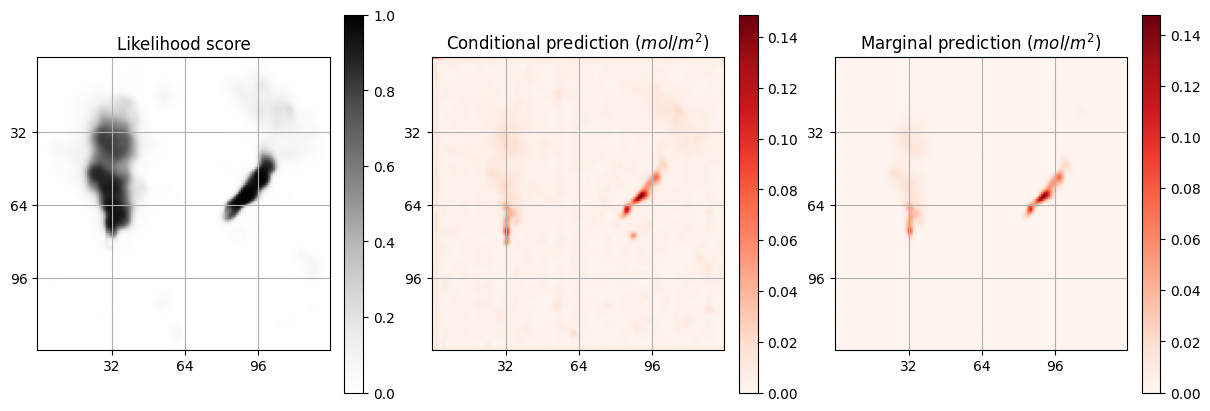

In [6]:
# determine gamma
with xr.open_dataset("./resources/emit/obs_crop.nc") as ds:
    obs = ds["obs"]
    observation_angle = obs.isel(bands=2)
    solar_angle = obs.isel(bands=4)

gamma = 1 / np.cos(np.deg2rad(solar_angle)) + 1 / np.cos(np.deg2rad(observation_angle))

print(f"Mean gamma for crop: {gamma.values.mean():.2f}\n")

# remove gamma from our marginal and conditional predictions
yhat_concentration = yhat_gamma_concentration.copy()
yhat_concentration.loc[{"prediction": ["marginal", "conditional"]}] /= gamma.values

# visualize
plot_predictions(yhat_concentration, subplot_props, units=r"$mol / m^2$")

## Using predictions

After determining per-pixel methane concentrations, the next steps would typically be masking plumes and quantifying the emissions rate of these plumes.
Various approaches can be taken to either of these tasks and it is beyond the scope of this notebook to demonstrate them.
For a discussion of our approach to masking and quantification refer to the docs [here](https://orbio-earth.github.io/project-eucalyptus/Postprocessing.html).